# Video Deltas

We will explore the video deltas to see the distribution for the values in the diff. We want to see visually what type of distribution the video deltas follow.

In [1]:
import glob
import os
import cv2
import numpy as np
import tqdm
from matplotlib import pyplot as plt

In [3]:
lebron_fnames = list(glob.glob('/home/robocup/videos/lebron/*.png'))
westlake_fnames = list(glob.glob('/home/robocup/videos/westlake/*.png'))
la_fnames = list(glob.glob('/home/robocup/videos/latraffic/*.png'))

Load in all of the images sequentially and we can find the deltas that way. We'll just make it easy to load the images inside a folder that correspond to individual frames of a video, load them in (assuming that the filenames can be sorted to get the correct ordering of frames), and calculate the diffs between each frame.

In [4]:
def load_image(fname):
    return cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)

def diffs(fnames, limit=1000):
    """Returns diffs of each frame in a video. Limits to <limit> frames or else
    it takes too long to calculate the diffs. Returns the diffs as a numpy array
    as (num_frames - 1, height, width, rgb)"""
    fnames = list(sorted(fnames))[:limit]
    frames = [load_image(fname) for fname in tqdm.tqdm(fnames)]
    frames = np.array(frames)
    
    flat_frames = frames.astype(np.int16)
    flat_diffs = flat_frames[1:] - flat_frames[:-1]
    return flat_diffs

In [5]:
lebron_diffs = diffs(lebron_fnames, limit=300)
westlake_diffs = diffs(westlake_fnames, limit=300)
la_diffs = diffs(la_fnames, limit=300)

100%|██████████| 241/241 [00:05<00:00, 44.86it/s]


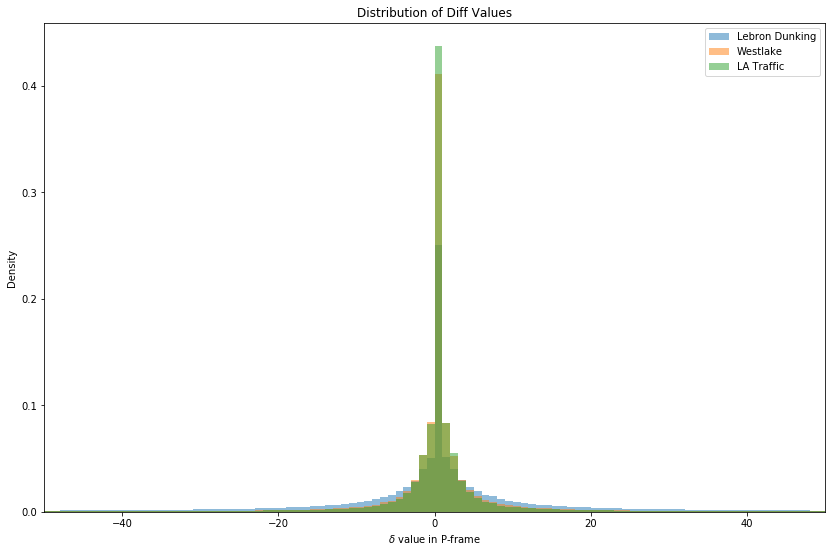

In [61]:
plt.figure(figsize=(14, 9))
plt.title('Distribution of Diff Values')
# plt.subplot(1, 3, 1)
# plt.hist(lebron_diffs.flatten(), bins=150, density=True)
# plt.subplot(1, 3, 2)
# plt.hist(westlake_diffs.flatten(), bins=150, density=True)
# plt.subplot(1, 3, 3)
# plt.hist(la_diffs.flatten(), bins=150, density=True)
bins = np.linspace(-256, 256, 513)
plt.hist(lebron_diffs.flatten(), bins=bins, density=True, alpha=0.5, label='Lebron Dunking')
plt.hist(westlake_diffs.flatten(), bins=bins, density=True, alpha=0.5, label='Westlake')
plt.hist(la_diffs.flatten(), bins=bins, density=True, alpha=0.5, label='LA Traffic')
plt.xlabel(r'$\delta$ value in P-frame')
plt.ylabel('Density')
plt.xlim(xmin=-50, xmax=50)
plt.legend(loc='upper right')
plt.show()

Let's also plot what some of these diffs look like anyway, just so we can see visually what's happening here. Diffs essentially only see movement values, and all of the background will essentially be sparse or very small values.

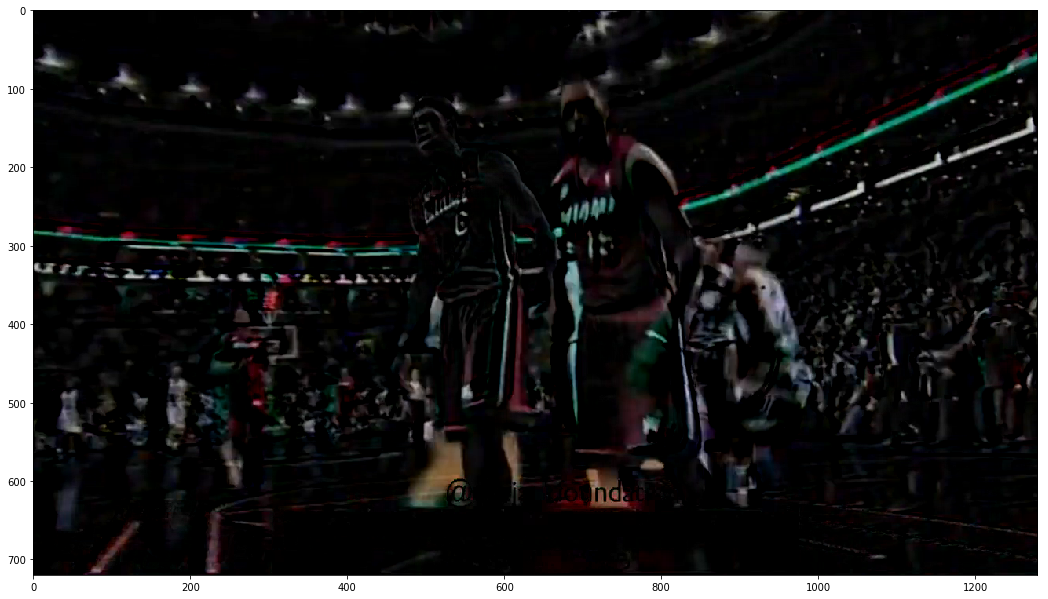

In [119]:
# plt.figure(figsize=(16, 48))
# plt.subplot(3, 1, 1)
# plt.imshow(lebron_diffs[20])
# plt.subplot(3, 1, 2)
# plt.imshow(westlake_diffs[20])
# plt.subplot(3, 1, 3)
# plt.imshow(la_diffs[20])
# plt.show()

plt.figure(figsize=(18, 18))
plt.imshow(lebron_diffs[-90])
plt.show()


## Guesses for the Distribution

This looks like a Laplacian distribution except with extra sparsity. Let's just guess and see what values work well to approximate some of the distributions we found. It's hard to analytically find a solution because our values are inherently quantized, so we'll sample from the distribution we guess.

In [71]:
import torch
import torch.distributions as ds
import random

In [91]:
def sample_laplace(scale, sparsity, num_samples):
    """Returns a sample of laplacian with sparsity and quantized to integers."""
    a = ds.Laplace(torch.zeros(num_samples), torch.ones(num_samples) * scale)
    # Sample and sparsify
    sample = a.sample().numpy()
    for index in range(len(sample)):
        if random.random() < sparsity:
            sample[index] = 0
    sample = np.round(sample)
    return sample

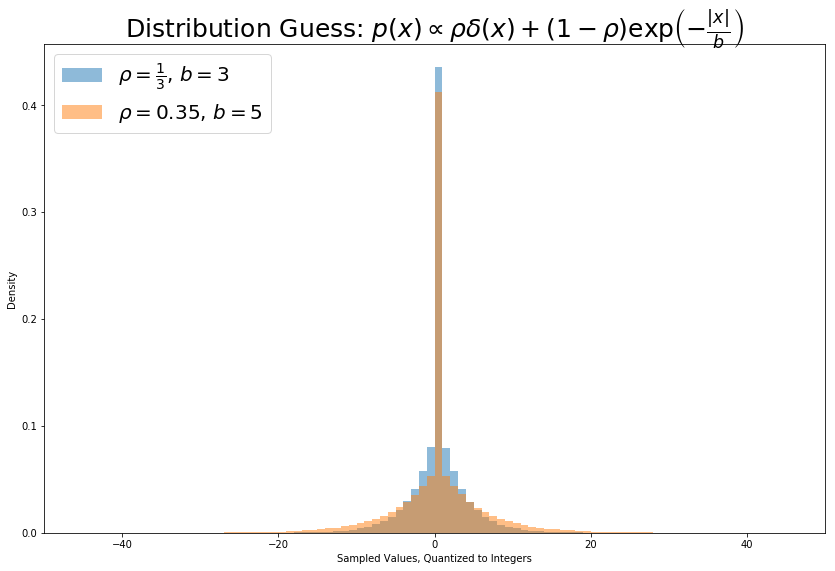

In [97]:
sample1 = sample_laplace(3, 0.3333, 1000000)
sample2 = sample_laplace(5, 0.35, 1000000)

# Round to quantize to integer

onesample = r"$p(x) \propto \rho \delta(x) + (1 - \rho) \exp\left(- \frac{|x|}{100}$"


plt.figure(figsize=(14, 9))
plt.title(r'Distribution Guess: $p(x) \propto \rho \delta(x) + (1 - \rho) \exp\left(- \frac{|x|}{b}\right)$',
          fontsize=25)
# plt.subplot(1, 3, 1)
# plt.hist(lebron_diffs.flatten(), bins=150, density=True)
# plt.subplot(1, 3, 2)
# plt.hist(westlake_diffs.flatten(), bins=150, density=True)
# plt.subplot(1, 3, 3)
# plt.hist(la_diffs.flatten(), bins=150, density=True)
bins = np.linspace(-256, 256, 513)
plt.hist(sample1, density=True, alpha=0.5, bins=bins, label=r"$\rho = \frac{1}{3}$, $b = 3$")
plt.hist(sample2, density=True, alpha=0.5, bins=bins, label=r"$\rho = 0.35$, $b = 5$")
plt.xlabel(r'Sampled Values, Quantized to Integers')
plt.ylabel('Density')
plt.xlim(xmin=-50, xmax=50)
plt.legend(loc=2, fontsize=20)
plt.show()